In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import class_weight

import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

In [2]:
# --- Constants ---
DATA_DIR = 'retinopathy_dataset'
TRAIN_IMG_DIR = os.path.join(DATA_DIR, 'train_images')
TRAIN_CSV_PATH = os.path.join(DATA_DIR, 'train.csv')

IMG_SIZE = 224
BATCH_SIZE = 32
RANDOM_STATE = 42

In [3]:
# Load labels and create file paths
df = pd.read_csv(TRAIN_CSV_PATH)
# Create a binary label: 0 for 'No DR', 1 for 'DR'
df['label'] = df['diagnosis'].apply(lambda x: 1 if x > 0 else 0)
# Create a full path column for the images
df['filepath'] = df['id_code'].apply(lambda x: os.path.join(TRAIN_IMG_DIR, x + '.png'))

# Ensure all files exist
df['file_exists'] = df['filepath'].apply(os.path.exists)
print(f"Original records: {len(df)}")
df = df[df['file_exists']].copy()
print(f"Records with existing files: {len(df)}")
df.drop('file_exists', axis=1, inplace=True)

# Split the dataframe into training and validation sets
train_df, val_df = train_test_split(
    df,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=df['label'] # Stratify to maintain class distribution
)

print(f"Training samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")
print("\nTraining set distribution:\n", train_df['label'].value_counts(normalize=True))
print("\nValidation set distribution:\n", val_df['label'].value_counts(normalize=True))


Original records: 3662
Records with existing files: 3662
Training samples: 2929
Validation samples: 733

Training set distribution:
 label
1    0.506999
0    0.493001
Name: proportion, dtype: float64

Validation set distribution:
 label
1    0.507503
0    0.492497
Name: proportion, dtype: float64


In [7]:
# --- Data Augmentation and Generators ---

# Use ResNet50's specific preprocessing function
# Augment training data to improve generalization
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Only preprocess validation data (no augmentation)
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# Create generators to load images in batches from the dataframe
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='filepath',
    y_col='label',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='raw' # Use 'raw' for single-column integer labels
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='filepath',
    y_col='label',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='raw',
    shuffle=False # No need to shuffle validation data
)

# Calculate class weights to handle data imbalance
class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(train_df['label']),
    y=train_df['label']
)
class_weights_dict = {i : class_weights[i] for i in range(len(class_weights))}
print("\nClass Weights:", class_weights_dict)

Found 2929 validated image filenames.
Found 733 validated image filenames.

Class Weights: {0: 1.014196675900277, 1: 0.9861952861952862}


In [8]:
def build_model(input_shape=(IMG_SIZE, IMG_SIZE, 3)):
    # Load ResNet50 base model with pre-trained ImageNet weights
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

    # Build the custom head
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    output = Dense(1, activation='sigmoid')(x) # Sigmoid for binary classification

    model = Model(inputs=base_model.input, outputs=output)
    
    return model, base_model

model, base_model = build_model()
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 24,113,537 (91.99 MB)

 Trainable params: 24,059,905 (91.78 MB)

 Non-trainable params: 53,632 (209.50 KB)

In [9]:
# --- Stage 1: Train only the top layers ---

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Callbacks
model_path = 'retinopathy_best_model.h5'
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6),
    ModelCheckpoint(filepath=model_path, monitor='val_loss', save_best_only=True)
]

print("--- Starting Stage 1: Feature Extraction ---")
history_1 = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=10, # Train for a limited number of epochs
    validation_data=val_generator,
    validation_steps=len(val_generator),
    callbacks=callbacks,
    class_weight=class_weights_dict
)

--- Starting Stage 1: Feature Extraction ---


/opt/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8913 - loss: 0.3294

92/92 ━━━━━━━━━━━━━━━━━━━━ 218s 2s/step - accuracy: 0.8917 - loss: 0.3282 - val_accuracy: 0.9441 - val_loss: 0.1476 - learning_rate: 0.0010
Epoch 2/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 212s 2s/step - accuracy: 0.9529 - loss: 0.1482 - val_accuracy: 0.9318 - val_loss: 0.1948 - learning_rate: 0.0010
Epoch 3/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9605 - loss: 0.1178

92/92 ━━━━━━━━━━━━━━━━━━━━ 228s 2s/step - accuracy: 0.9604 - loss: 0.1179 - val_accuracy: 0.9604 - val_loss: 0.1164 - learning_rate: 0.0010
Epoch 4/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 227s 2s/step - accuracy: 0.9589 - loss: 0.1288 - val_accuracy: 0.9536 - val_loss: 0.1259 - learning_rate: 0.0010
Epoch 5/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 233s 3s/step - accuracy: 0.9551 - loss: 0.1225 - val_accuracy: 0.9536 - val_loss: 0.1247 - learning_rate: 0.0010
Epoch 6/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9605 - loss: 0.1200

92/92 ━━━━━━━━━━━━━━━━━━━━ 240s 3s/step - accuracy: 0.9605 - loss: 0.1199 - val_accuracy: 0.9604 - val_loss: 0.1114 - learning_rate: 2.0000e-04
Epoch 7/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9727 - loss: 0.1001

92/92 ━━━━━━━━━━━━━━━━━━━━ 241s 3s/step - accuracy: 0.9727 - loss: 0.1001 - val_accuracy: 0.9604 - val_loss: 0.1086 - learning_rate: 2.0000e-04
Epoch 8/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9654 - loss: 0.1025

92/92 ━━━━━━━━━━━━━━━━━━━━ 225s 2s/step - accuracy: 0.9654 - loss: 0.1025 - val_accuracy: 0.9618 - val_loss: 0.1052 - learning_rate: 2.0000e-04
Epoch 9/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 242s 3s/step - accuracy: 0.9734 - loss: 0.0848 - val_accuracy: 0.9645 - val_loss: 0.1061 - learning_rate: 2.0000e-04
Epoch 10/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9581 - loss: 0.1219

92/92 ━━━━━━━━━━━━━━━━━━━━ 236s 3s/step - accuracy: 0.9582 - loss: 0.1218 - val_accuracy: 0.9645 - val_loss: 0.1051 - learning_rate: 2.0000e-04


In [10]:
# --- Stage 2: Fine-Tuning ---

# Unfreeze the top convolutional blocks of ResNet50
# The exact number can be tuned; let's unfreeze from conv5_block1 onwards
for layer in base_model.layers[143:]: # ResNet50 has 175 layers, 143 is a good starting point
    layer.trainable = True

# Re-compile the model with a very low learning rate
model.compile(
    optimizer=Adam(learning_rate=1e-5), # Crucial to use a low LR for fine-tuning
    loss='binary_crossentropy',
    metrics=['accuracy']
)

print("\n--- Starting Stage 2: Fine-Tuning ---")
history_2 = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=15, # Train for more epochs, EarlyStopping will handle it
    validation_data=val_generator,
    validation_steps=len(val_generator),
    callbacks=callbacks, # Continue using the same callbacks
    class_weight=class_weights_dict
)


--- Starting Stage 2: Fine-Tuning ---
Epoch 1/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 230s 2s/step - accuracy: 0.9543 - loss: 0.1352 - val_accuracy: 0.9591 - val_loss: 0.1243 - learning_rate: 1.0000e-05
Epoch 2/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 250s 3s/step - accuracy: 0.9667 - loss: 0.0958 - val_accuracy: 0.9577 - val_loss: 0.1203 - learning_rate: 1.0000e-05
Epoch 3/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 271s 3s/step - accuracy: 0.9646 - loss: 0.1063 - val_accuracy: 0.9604 - val_loss: 0.1123 - learning_rate: 1.0000e-05
Epoch 4/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 281s 3s/step - accuracy: 0.9635 - loss: 0.0984 - val_accuracy: 0.9604 - val_loss: 0.1095 - learning_rate: 1.0000e-05
Epoch 5/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9715 - loss: 0.0747

92/92 ━━━━━━━━━━━━━━━━━━━━ 282s 3s/step - accuracy: 0.9715 - loss: 0.0748 - val_accuracy: 0.9632 - val_loss: 0.0990 - learning_rate: 1.0000e-05
Epoch 6/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 289s 3s/step - accuracy: 0.9716 - loss: 0.0794 - val_accuracy: 0.9632 - val_loss: 0.1023 - learning_rate: 1.0000e-05
Epoch 7/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 287s 3s/step - accuracy: 0.9829 - loss: 0.0468 - val_accuracy: 0.9673 - val_loss: 0.0994 - learning_rate: 1.0000e-05
Epoch 8/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9831 - loss: 0.0540

92/92 ━━━━━━━━━━━━━━━━━━━━ 304s 3s/step - accuracy: 0.9831 - loss: 0.0541 - val_accuracy: 0.9659 - val_loss: 0.0979 - learning_rate: 2.0000e-06
Epoch 9/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9809 - loss: 0.0583

92/92 ━━━━━━━━━━━━━━━━━━━━ 325s 4s/step - accuracy: 0.9809 - loss: 0.0584 - val_accuracy: 0.9659 - val_loss: 0.0974 - learning_rate: 2.0000e-06
Epoch 10/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9801 - loss: 0.0539

92/92 ━━━━━━━━━━━━━━━━━━━━ 292s 3s/step - accuracy: 0.9801 - loss: 0.0539 - val_accuracy: 0.9659 - val_loss: 0.0944 - learning_rate: 2.0000e-06
Epoch 11/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 298s 3s/step - accuracy: 0.9825 - loss: 0.0646 - val_accuracy: 0.9673 - val_loss: 0.0952 - learning_rate: 2.0000e-06
Epoch 12/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 328s 4s/step - accuracy: 0.9807 - loss: 0.0545 - val_accuracy: 0.9673 - val_loss: 0.0950 - learning_rate: 2.0000e-06
Epoch 13/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9791 - loss: 0.0558

92/92 ━━━━━━━━━━━━━━━━━━━━ 328s 4s/step - accuracy: 0.9791 - loss: 0.0558 - val_accuracy: 0.9673 - val_loss: 0.0944 - learning_rate: 1.0000e-06
Epoch 14/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9832 - loss: 0.0490

92/92 ━━━━━━━━━━━━━━━━━━━━ 349s 4s/step - accuracy: 0.9832 - loss: 0.0490 - val_accuracy: 0.9673 - val_loss: 0.0938 - learning_rate: 1.0000e-06
Epoch 15/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 325s 4s/step - accuracy: 0.9804 - loss: 0.0552 - val_accuracy: 0.9673 - val_loss: 0.0944 - learning_rate: 1.0000e-06


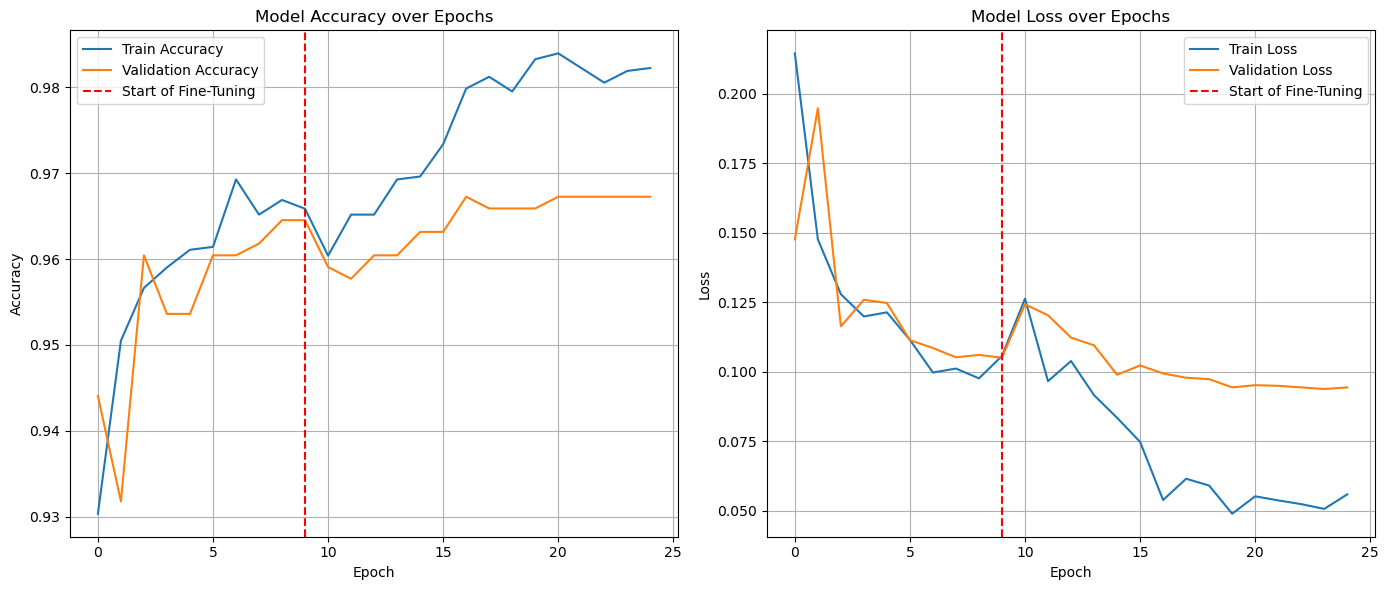

23/23 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.9775 - loss: 0.0690

Final Validation Accuracy: 96.73%
Final Validation Loss: 0.0938
23/23 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step

Classification Report:
                  precision    recall  f1-score   support

Not Diabetic (0)       0.97      0.96      0.97       361
    Diabetic (1)       0.97      0.97      0.97       372

        accuracy                           0.97       733
       macro avg       0.97      0.97      0.97       733
    weighted avg       0.97      0.97      0.97       733



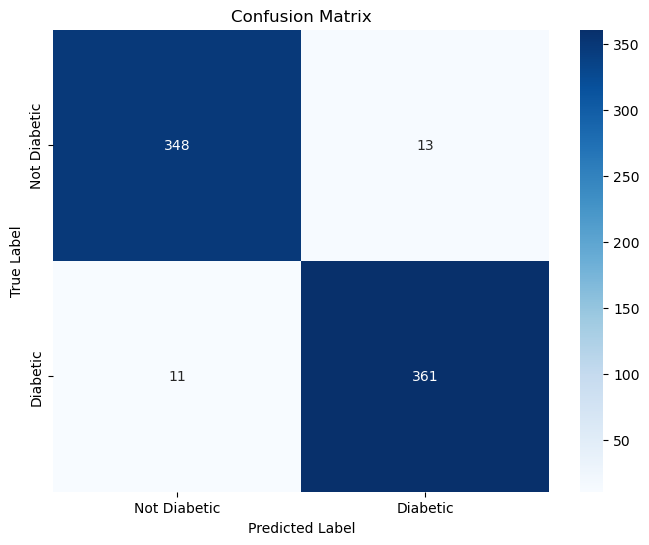

In [11]:
# Combine history from both training stages
history_full = {}
for key in history_1.history.keys():
    history_full[key] = history_1.history[key] + history_2.history[key]

# --- Plot Accuracy and Loss ---
plt.figure(figsize=(14, 6))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history_full['accuracy'], label='Train Accuracy')
plt.plot(history_full['val_accuracy'], label='Validation Accuracy')
plt.axvline(x=len(history_1.history['accuracy'])-1, color='r', linestyle='--', label='Start of Fine-Tuning')
plt.title('Model Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history_full['loss'], label='Train Loss')
plt.plot(history_full['val_loss'], label='Validation Loss')
plt.axvline(x=len(history_1.history['loss'])-1, color='r', linestyle='--', label='Start of Fine-Tuning')
plt.title('Model Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


# --- Final Evaluation ---
# Load the best performing model saved by ModelCheckpoint
model.load_weights(model_path)

# Evaluate on the validation set
loss, acc = model.evaluate(val_generator)
print(f"\nFinal Validation Accuracy: {acc*100:.2f}%")
print(f"Final Validation Loss: {loss:.4f}")

# Predictions and Classification Report
val_generator.reset()
preds = model.predict(val_generator)
pred_labels = (preds > 0.5).astype(int).flatten()

# Get true labels
true_labels = val_df['label'].values

print("\nClassification Report:")
print(classification_report(true_labels, pred_labels, target_names=['Not Diabetic (0)', 'Diabetic (1)']))

# Confusion Matrix
cm = confusion_matrix(true_labels, pred_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Not Diabetic', 'Diabetic'], 
            yticklabels=['Not Diabetic', 'Diabetic'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()